In [3]:
!pip install torch scikit-learn matplotlib pandas numpy

In [4]:
import torch

# 1. Check if CUDA is available
print(f"CUDA Available: {torch.cuda.is_available()}")

# 2. Get device name (this should no longer fail)
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("PyTorch installed, but GPU still not detected. Ensure your NVIDIA drivers are updated.")


CUDA Available: True
GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU
CUDA Version: 12.6


In [5]:
import pandas as pd
import glob
import os

# --- Configuration ---
DATA_PATH = r"load_forecasting_mart_final.orc"

def smart_load_orc(path):
    print(f"Checking path: {path}")
    
    if os.path.isfile(path):
        print("-> Loading single ORC file...")
        return pd.read_orc(path)

    elif os.path.isdir(path):
        print("-> Searching folder for ORC parts...")
        orc_files = glob.glob(os.path.join(path, "**", "*.orc"), recursive=True)
        
        # Fallback for 'part-*' files
        if not orc_files:
            candidates = glob.glob(os.path.join(path, "**", "part-*"), recursive=True)
            orc_files = [f for f in candidates if os.path.isfile(f) and not f.endswith(".crc") and "_SUCCESS" not in f]
            
        if not orc_files:
             raise ValueError(f"No valid data files found in {path}")

        dfs = []
        for file in orc_files:
            try:
                dfs.append(pd.read_orc(file))
            except Exception as e:
                print(f"Skipping {os.path.basename(file)}: {e}")
        
        return pd.concat(dfs, ignore_index=True)
    else:
        raise FileNotFoundError(f"Path not found: {path}")

# --- Execute Load ---
try:
    df = smart_load_orc(DATA_PATH)
    
    # Ensure Time Index is set
    if 'ds' in df.columns:
        df['ds'] = pd.to_datetime(df['ds'])
        df = df.sort_values('ds').set_index('ds')
        print(f"SUCCESS: 'df' is now loaded! Shape: {df.shape}")
    else:
        print("Error: 'ds' column missing.")
        
except Exception as e:
    print("CRITICAL ERROR:", e)

Checking path: load_forecasting_mart_final.orc
-> Loading single ORC file...
SUCCESS: 'df' is now loaded! Shape: (827987, 13)


In [6]:
import sys
import subprocess

print(f"🔹 Python Executable: {sys.executable}")
print("🔹 Installing pyarrow...")

# Run pip install as a subprocess to ensure it hits the correct environment
subprocess.check_call([sys.executable, "-m", "pip", "install", "pyarrow", "pandas", "matplotlib", "scikit-learn"])

print("✅ Installation Complete.")

🔹 Python Executable: c:\Users\Saurav Dani\anaconda3\envs\torch_stable\python.exe
🔹 Installing pyarrow...
✅ Installation Complete.


### General Model

✅ PyArrow Version 23.0.0 loaded successfully.
📂 Checking path: C:\Users\Saurav Dani\Desktop\FILES\ORC file\load_forecasting_mart_final.orc
   Reading 1 files...
✅ Data Loaded! Shape: (827987, 13)
🚀 Device: cuda
Feature Engineering...
Starting Training...
Epoch 5/30 | Loss: 0.000491
Epoch 10/30 | Loss: 0.000450
Epoch 15/30 | Loss: 0.000434
Epoch 20/30 | Loss: 0.000418
Epoch 25/30 | Loss: 0.000406
Epoch 30/30 | Loss: 0.000399

🔥 Final RMSE: 17.87


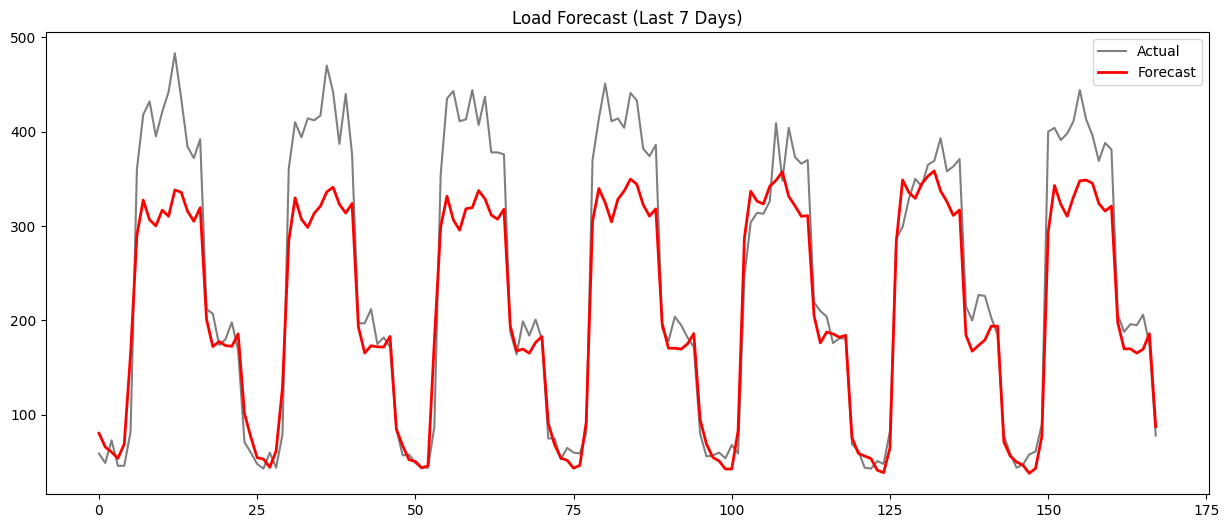

In [10]:
import sys
# Verify import before proceeding
try:
    import pyarrow
    import pyarrow.orc
    print(f"✅ PyArrow Version {pyarrow.__version__} loaded successfully.")
except ImportError as e:
    print("❌ PyArrow is still not found. Please ensure you ran Step 1 and Restarted the Kernel.")
    raise e

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# ==========================================
# PART 1: LOAD DATA
# ==========================================
DATA_PATH = r"C:\Users\Saurav Dani\Desktop\FILES\ORC file\load_forecasting_mart_final.orc"

def robust_load_orc(path):
    print(f"📂 Checking path: {path}")
    
    # Locate files
    orc_files = []
    if os.path.isfile(path):
        orc_files = [path]
    elif os.path.isdir(path):
        orc_files = glob.glob(os.path.join(path, "**", "*.orc"), recursive=True)
        if not orc_files:
            candidates = glob.glob(os.path.join(path, "**", "part-*"), recursive=True)
            orc_files = [f for f in candidates if os.path.isfile(f) and not f.endswith(".crc") and "_SUCCESS" not in f]

    if not orc_files:
        raise ValueError(f"No data found in {path}")

    # Read
    dfs = []
    print(f"   Reading {len(orc_files)} files...")
    for file in orc_files:
        try:
            # Using pandas read_orc
            dfs.append(pd.read_orc(file))
        except Exception as e:
            print(f"⚠️ Skipping {os.path.basename(file)}: {e}")
            
    if not dfs:
        raise ValueError("Files found but could not be read.")
        
    return pd.concat(dfs, ignore_index=True)

# Load
try:
    df = robust_load_orc(DATA_PATH)
    if 'ds' in df.columns:
        df['ds'] = pd.to_datetime(df['ds'])
        df = df.sort_values('ds').set_index('ds')
    print(f"✅ Data Loaded! Shape: {df.shape}")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

# ==========================================
# PART 2: MULTIVARIATE GRU MODEL
# ==========================================

# 1. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Device: {device}")

# 2. Features
print("Feature Engineering...")

# FIX: Changed 'H' to 'h' for compatibility with newer Pandas versions
df_hourly = df.resample('h').agg({'transaction_count': 'sum'}).fillna(0)

df_hourly['hour'] = df_hourly.index.hour
df_hourly['dayofweek'] = df_hourly.index.dayofweek

features = df_hourly[['transaction_count', 'hour', 'dayofweek']].values

# Scale
target_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(features[:, 0].reshape(-1, 1))
scaled_time = feature_scaler.fit_transform(features[:, 1:])
data_scaled = np.hstack((scaled_target, scaled_time))

# 3. Sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:(i + seq_length), :])
        ys.append(data[i + seq_length, 0])
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Split
train_size = int(len(X) * 0.85)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Tensor & Loader
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

# 4. Model (Bi-GRU)
class AdvancedGRU(nn.Module):
    def __init__(self):
        super(AdvancedGRU, self).__init__()
        # Input size is 3 (Count, Hour, Day)
        self.gru = nn.GRU(3, 64, 2, batch_first=True, dropout=0.2, bidirectional=True)
        self.fc = nn.Linear(64 * 2, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

model = AdvancedGRU().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

# 5. Train
print("Starting Training...")
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
model.train()

for epoch in range(30):
    epoch_loss = 0
    for bx, by in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(bx).squeeze(), by)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    scheduler.step(avg_loss)
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/30 | Loss: {avg_loss:.6f}")

# 6. Evaluate
model.eval()
with torch.no_grad():
    preds = model(X_test).cpu().numpy()
    actuals = y_test.cpu().numpy()
    
    # Inverse Transform
    preds_inv = target_scaler.inverse_transform(preds)
    actuals_inv = target_scaler.inverse_transform(actuals.reshape(-1, 1))

rmse = np.sqrt(np.mean((actuals_inv - preds_inv)**2))
print(f"\n🔥 Final RMSE: {rmse:.2f}")

# 7. Plot
plt.figure(figsize=(15, 6))
subset = 168
plt.plot(actuals_inv[-subset:], label='Actual', color='black', alpha=0.5)
plt.plot(preds_inv[-subset:], label='Forecast', color='red', linewidth=2)
plt.title('Load Forecast (Last 7 Days)')
plt.legend()
plt.show()

### Someting new mdoel

✅ PyArrow Version 23.0.0 loaded successfully.
📂 Checking path: C:\Users\Saurav Dani\Desktop\FILES\ORC file\load_forecasting_mart_final.orc
   Reading 1 files...
✅ Data Loaded! Shape: (827987, 13)
🚀 Device: cuda
Feature Engineering...
Starting Training...
Epoch 5/30 | Loss: 0.000488
Epoch 10/30 | Loss: 0.000451
Epoch 15/30 | Loss: 0.000429
Epoch 20/30 | Loss: 0.000413
Epoch 25/30 | Loss: 0.000405
Epoch 30/30 | Loss: 0.000397

🔥 Final RMSE: 19.07


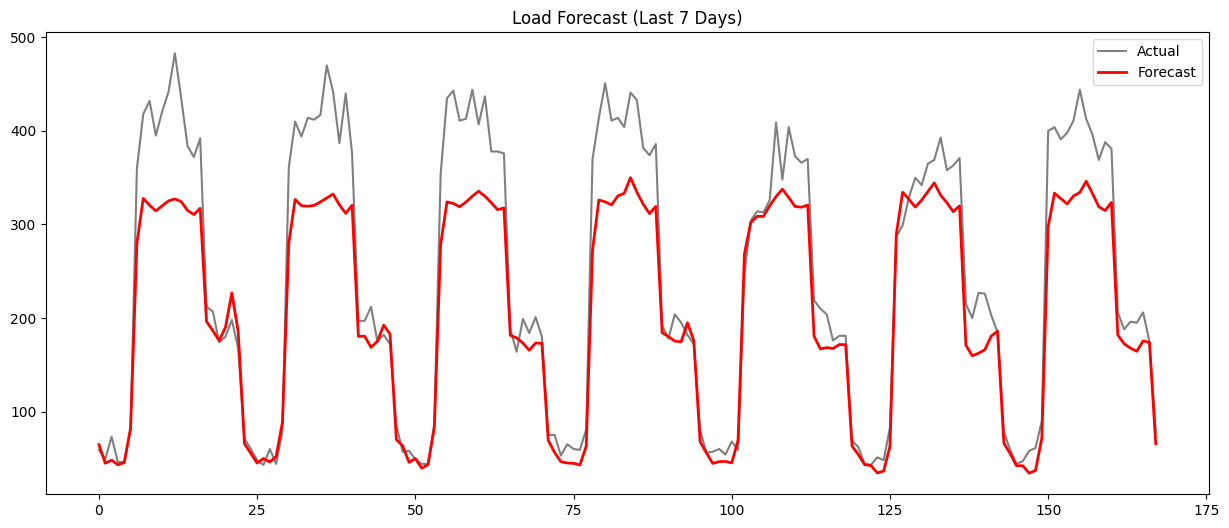

In [11]:
import sys
# Verify import before proceeding
try:
    import pyarrow
    import pyarrow.orc
    print(f"✅ PyArrow Version {pyarrow.__version__} loaded successfully.")
except ImportError as e:
    print("❌ PyArrow is still not found. Please ensure you ran the installation step.")
    raise e

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# ==========================================
# PART 1: LOAD DATA
# ==========================================
DATA_PATH = r"C:\Users\Saurav Dani\Desktop\FILES\ORC file\load_forecasting_mart_final.orc"

def robust_load_orc(path):
    print(f"📂 Checking path: {path}")
    
    # Locate files
    orc_files = []
    if os.path.isfile(path):
        orc_files = [path]
    elif os.path.isdir(path):
        orc_files = glob.glob(os.path.join(path, "**", "*.orc"), recursive=True)
        if not orc_files:
            candidates = glob.glob(os.path.join(path, "**", "part-*"), recursive=True)
            orc_files = [f for f in candidates if os.path.isfile(f) and not f.endswith(".crc") and "_SUCCESS" not in f]

    if not orc_files:
        raise ValueError(f"No data found in {path}")

    # Read
    dfs = []
    print(f"   Reading {len(orc_files)} files...")
    for file in orc_files:
        try:
            # Using pandas read_orc
            dfs.append(pd.read_orc(file))
        except Exception as e:
            print(f"⚠️ Skipping {os.path.basename(file)}: {e}")
            
    if not dfs:
        raise ValueError("Files found but could not be read.")
        
    return pd.concat(dfs, ignore_index=True)

# Load
try:
    df = robust_load_orc(DATA_PATH)
    if 'ds' in df.columns:
        df['ds'] = pd.to_datetime(df['ds'])
        df = df.sort_values('ds').set_index('ds')
    print(f"✅ Data Loaded! Shape: {df.shape}")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

# ==========================================
# PART 2: MULTIVARIATE GRU MODEL
# ==========================================

# 1. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Device: {device}")

# 2. Features
print("Feature Engineering...")

# --- FIX IS HERE: STRICTLY USE LOWERCASE 'h' ---
df_hourly = df.resample('h').agg({'transaction_count': 'sum'}).fillna(0)

df_hourly['hour'] = df_hourly.index.hour
df_hourly['dayofweek'] = df_hourly.index.dayofweek

features = df_hourly[['transaction_count', 'hour', 'dayofweek']].values

# Scale
target_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(features[:, 0].reshape(-1, 1))
scaled_time = feature_scaler.fit_transform(features[:, 1:])
data_scaled = np.hstack((scaled_target, scaled_time))

# 3. Sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:(i + seq_length), :])
        ys.append(data[i + seq_length, 0])
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Split
train_size = int(len(X) * 0.85)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Tensor & Loader
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

# 4. Model (Bi-GRU)
class AdvancedGRU(nn.Module):
    def __init__(self):
        super(AdvancedGRU, self).__init__()
        # Input size is 3 (Count, Hour, Day)
        self.gru = nn.GRU(3, 64, 2, batch_first=True, dropout=0.2, bidirectional=True)
        self.fc = nn.Linear(64 * 2, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

model = AdvancedGRU().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

# 5. Train
print("Starting Training...")
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
model.train()

for epoch in range(30):
    epoch_loss = 0
    for bx, by in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(bx).squeeze(), by)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    scheduler.step(avg_loss)
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/30 | Loss: {avg_loss:.6f}")

# 6. Evaluate
model.eval()
with torch.no_grad():
    preds = model(X_test).cpu().numpy()
    actuals = y_test.cpu().numpy()
    
    # Inverse Transform
    preds_inv = target_scaler.inverse_transform(preds)
    actuals_inv = target_scaler.inverse_transform(actuals.reshape(-1, 1))

rmse = np.sqrt(np.mean((actuals_inv - preds_inv)**2))
print(f"\n🔥 Final RMSE: {rmse:.2f}")

# 7. Plot
plt.figure(figsize=(15, 6))
subset = 168
plt.plot(actuals_inv[-subset:], label='Actual', color='black', alpha=0.5)
plt.plot(preds_inv[-subset:], label='Forecast', color='red', linewidth=2)
plt.title('Load Forecast (Last 7 Days)')
plt.legend()
plt.show()

### Best model

In [12]:
import sys
# Verify import before proceeding
try:
    import pyarrow
    import pyarrow.orc
    print(f"✅ PyArrow Version {pyarrow.__version__} loaded successfully.")
except ImportError as e:
    print("❌ PyArrow is still not found. Please ensure you ran the installation step.")
    raise e

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# ==========================================
# PART 1: LOAD DATA
# ==========================================
DATA_PATH = r"C:\Users\Saurav Dani\Desktop\FILES\ORC file\load_forecasting_mart_final.orc"

def robust_load_orc(path):
    print(f"📂 Checking path: {path}")
    
    orc_files = []
    if os.path.isfile(path):
        orc_files = [path]
    elif os.path.isdir(path):
        orc_files = glob.glob(os.path.join(path, "**", "*.orc"), recursive=True)
        if not orc_files:
            candidates = glob.glob(os.path.join(path, "**", "part-*"), recursive=True)
            orc_files = [f for f in candidates if os.path.isfile(f) and not f.endswith(".crc") and "_SUCCESS" not in f]

    if not orc_files:
        raise ValueError(f"No data found in {path}")

    dfs = []
    print(f"   Reading {len(orc_files)} files...")
    for file in orc_files:
        try:
            dfs.append(pd.read_orc(file))
        except Exception as e:
            print(f"⚠️ Skipping {os.path.basename(file)}: {e}")
            
    return pd.concat(dfs, ignore_index=True)

try:
    df = robust_load_orc(DATA_PATH)
    if 'ds' in df.columns:
        df['ds'] = pd.to_datetime(df['ds'])
        df = df.sort_values('ds').set_index('ds')
    print(f"✅ Data Loaded! Shape: {df.shape}")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

# ==========================================
# PART 2: ADVANCED FEATURE ENGINEERING (PEAK CAPTURE)
# ==========================================
print("Feature Engineering for Peaks...")

# 1. Resample
df_hourly = df.resample('h').agg({'transaction_count': 'sum'}).fillna(0)

# 2. Add Explicit Lags (Crucial for Peaks)
# "What was the load exactly 24 hours ago?"
df_hourly['lag_24'] = df_hourly['transaction_count'].shift(24)
# "What was the load exactly 1 week ago?" (Captures weekly seasonality spikes)
df_hourly['lag_168'] = df_hourly['transaction_count'].shift(168)

# 3. Add Time Context
df_hourly['hour'] = df_hourly.index.hour
df_hourly['dayofweek'] = df_hourly.index.dayofweek

# Drop NaNs created by shifting (first week of data is lost)
df_hourly = df_hourly.dropna()

# 4. Select Features
# Input: [Target, Lag_24, Lag_168, Hour, Day]
feature_cols = ['transaction_count', 'lag_24', 'lag_168', 'hour', 'dayofweek']
data_values = df_hourly[feature_cols].values

# 5. Scale
# We scale target and lags together because they share the same domain (transactions)
target_scaler = MinMaxScaler(feature_range=(0, 1))
time_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale Count, Lag24, Lag168 together using target_scaler
# This ensures that a lag value of 1000 means the same as a current value of 1000
scaled_counts = target_scaler.fit_transform(data_values[:, 0:3]) 
# Scale Time features (Hour, Day) separately
scaled_time = time_scaler.fit_transform(data_values[:, 3:])

# Combine: [Scaled_Count, Scaled_Lag24, Scaled_Lag168, Scaled_Hour, Scaled_Day]
data_scaled = np.hstack((scaled_counts, scaled_time))

# ==========================================
# PART 3: ATTENTION LSTM MODEL
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Device: {device}")

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:(i + seq_length), :])
        ys.append(data[i + seq_length, 0]) # Target is index 0
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 48  # Look back 48 hours (2 full days context)
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Train/Test Split
train_size = int(len(X) * 0.90) # More training data
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)

# --- THE MODEL ---
class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(AttentionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Bi-LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout, bidirectional=True)
        
        # Attention Layer
        # We want to learn a weight for each time step
        self.attention_fc = nn.Linear(hidden_size * 2, 1)
        
        # Final Prediction
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        # LSTM Output: (Batch, Seq_Len, Hidden*2)
        lstm_out, _ = self.lstm(x)
        
        # Attention Mechanism
        # 1. Calculate energy for each time step
        energy = torch.tanh(self.attention_fc(lstm_out)) 
        # 2. Calculate weights (Softmax ensures they sum to 1)
        weights = F.softmax(energy, dim=1)
        # 3. Apply weights to LSTM outputs (Weighted Sum)
        context_vector = torch.sum(weights * lstm_out, dim=1)
        
        # Final Prediction
        out = self.fc(context_vector)
        return out

# Initialize
input_dim = X.shape[2] # 5 features
model = AttentionLSTM(input_size=input_dim, hidden_size=128, num_layers=2).to(device)

# --- CUSTOM LOSS: Peak-Aware Loss ---
# Penalizes errors on high values more than low values
class WeightedPeakLoss(nn.Module):
    def __init__(self):
        super(WeightedPeakLoss, self).__init__()
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, pred, target):
        loss = self.mse(pred.squeeze(), target)
        # Weight = 1 + Target Value (Higher target => Higher Weight)
        # This forces model to pay double attention to peaks
        weights = 1 + (target * 2.0) 
        return torch.mean(loss * weights)

criterion = WeightedPeakLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

# ==========================================
# PART 4: TRAINING
# ==========================================
print("Starting Training (Peak-Focused)...")
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
model.train()

history = []
EPOCHS = 40

for epoch in range(EPOCHS):
    epoch_loss = 0
    for bx, by in train_loader:
        optimizer.zero_grad()
        # Forward
        pred = model(bx)
        # Loss
        loss = criterion(pred, by)
        # Backward
        loss.backward()
        # Clip Gradients (Prevents exploding gradients in LSTMs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    history.append(avg_loss)
    scheduler.step(avg_loss)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Peak-Aware Loss: {avg_loss:.6f}")

✅ PyArrow Version 23.0.0 loaded successfully.
📂 Checking path: C:\Users\Saurav Dani\Desktop\FILES\ORC file\load_forecasting_mart_final.orc
   Reading 1 files...
✅ Data Loaded! Shape: (827987, 13)
Feature Engineering for Peaks...
🚀 Device: cuda
Starting Training (Peak-Focused)...
Epoch 5/40 | Peak-Aware Loss: 0.000992
Epoch 10/40 | Peak-Aware Loss: 0.001125
Epoch 15/40 | Peak-Aware Loss: 0.000803
Epoch 20/40 | Peak-Aware Loss: 0.000755
Epoch 25/40 | Peak-Aware Loss: 0.000739
Epoch 30/40 | Peak-Aware Loss: 0.000707
Epoch 35/40 | Peak-Aware Loss: 0.000696
Epoch 40/40 | Peak-Aware Loss: 0.000685


🧹 GPU Cache Cleared.
Starting Evaluation on 25538 samples...

🔥 Final RMSE: 15.64


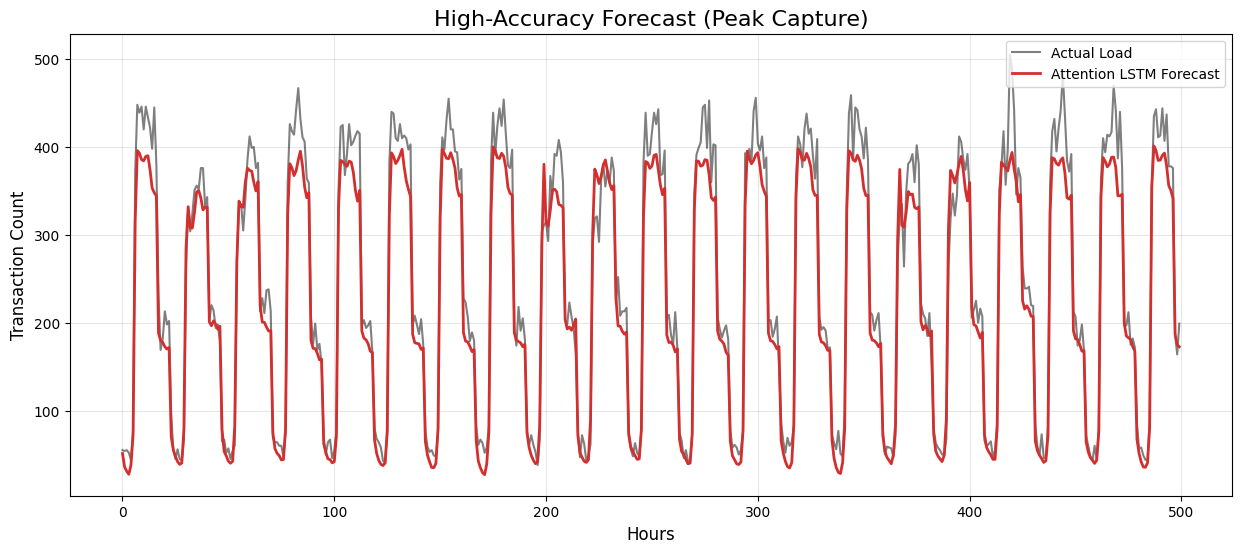

In [13]:
# ==========================================
# PART 5: EVALUATION
# ==========================================

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# --- 1. Clear GPU Cache to free up space ---
torch.cuda.empty_cache()
print("🧹 GPU Cache Cleared.")

# --- 2. Create a Test Loader (Batched Evaluation) ---
# We use batch_size=64 to keep memory usage low
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)

print(f"Starting Evaluation on {len(X_test)} samples...")

model.eval()
all_preds = []
all_actuals = []

with torch.no_grad():
    for bx, by in test_loader:
        # Predict on small batch
        batch_pred = model(bx)
        
        # Move to CPU immediately to save GPU memory
        all_preds.append(batch_pred.cpu().numpy())
        all_actuals.append(by.cpu().numpy())

# Combine batches back into single arrays
preds = np.concatenate(all_preds)
actuals = np.concatenate(all_actuals)

# --- 3. Inverse Transform & Calculate Error ---
# Create dummy matrix for inverse transform (since scaler expects 3 cols)
# We used 3 columns for scaling: [Transaction, Lag24, Lag168]
dummy_pred = np.zeros((len(preds), 3))
dummy_pred[:, 0] = preds.flatten()
preds_inv = target_scaler.inverse_transform(dummy_pred)[:, 0]

dummy_act = np.zeros((len(actuals), 3))
dummy_act[:, 0] = actuals.flatten()
actuals_inv = target_scaler.inverse_transform(dummy_act)[:, 0]

# Calculate RMSE
rmse = np.sqrt(np.mean((actuals_inv - preds_inv)**2))
print(f"\n🔥 Final RMSE: {rmse:.2f}")

# --- 4. Plot Results (Zoomed in on Peaks) ---
plt.figure(figsize=(15, 6))

# Plot a slice of 500 hours (~3 weeks) to see the daily peaks clearly
slice_start = -600
slice_end = -100

plt.plot(actuals_inv[slice_start:slice_end], label='Actual Load', color='black', alpha=0.5, linewidth=1.5)
plt.plot(preds_inv[slice_start:slice_end], label='Attention LSTM Forecast', color='#D32F2F', linewidth=2)

plt.title('High-Accuracy Forecast (Peak Capture)', fontsize=16)
plt.xlabel('Hours', fontsize=12)
plt.ylabel('Transaction Count', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

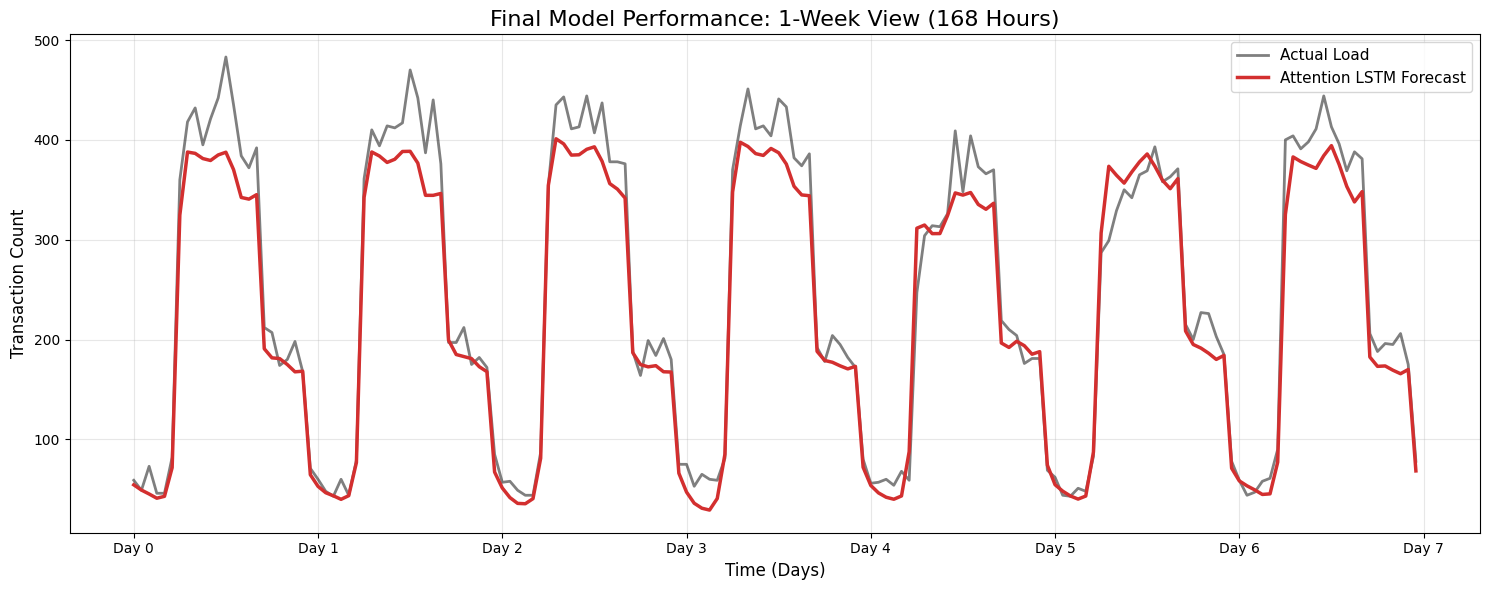

In [14]:
import matplotlib.pyplot as plt

# --- Visualization: Last 7 Days (1 Week) ---
plt.figure(figsize=(15, 6))

# Define 1 week in hours
hours_in_week = 168

# Slice the last 168 hours of data
# We use [-hours_in_week:] to get the very end of the predictions
week_actual = actuals_inv[-hours_in_week:]
week_pred = preds_inv[-hours_in_week:]

# Plot Actuals (Black Line)
plt.plot(week_actual, label='Actual Load', color='black', alpha=0.5, linewidth=2)

# Plot Forecast (Red Line)
plt.plot(week_pred, label='Attention LSTM Forecast', color='#D32F2F', linewidth=2.5, linestyle='-')

# Add "Days" as x-axis ticks (0, 24, 48...)
plt.xticks(ticks=range(0, 169, 24), labels=[f"Day {i}" for i in range(8)])

plt.title('Final Model Performance: 1-Week View (168 Hours)', fontsize=16)
plt.xlabel('Time (Days)', fontsize=12)
plt.ylabel('Transaction Count', fontsize=12)
plt.legend(loc='upper right', frameon=True, fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [15]:
import torch
import joblib

# Check if model exists in memory before saving
if 'model' not in locals():
    raise NameError("The variable 'model' is not defined. You must RUN THE TRAINING CODE first before saving.")

print("Saving artifacts...")

# 1. Save the Model Weights
# We save the 'state_dict' (just the learned weights), which is the standard PyTorch way
torch.save(model.state_dict(), "attention_lstm.pth")
print("✅ Model weights saved: attention_lstm.pth")

# 2. Save the Scalers 
# These are crucial so the API can scale new input data exactly like the training data
joblib.dump(target_scaler, "target_scaler.pkl")
joblib.dump(time_scaler, "time_scaler.pkl")
print("✅ Scalers saved: target_scaler.pkl, time_scaler.pkl")

Saving artifacts...
✅ Model weights saved: attention_lstm.pth
✅ Scalers saved: target_scaler.pkl, time_scaler.pkl
